In [1]:
# imports
from itertools import product
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from skimage.io import imread,imsave
# import os

# Upload pre-annotated images

In [11]:
from sahi.models.yolov8 import Yolov8DetectionModel
from ultralytics import YOLO
from sahi.predict import get_sliced_prediction
import torch
from PIL import Image
from time import time
from pathlib import Path
import mlflow
import json
import pprint

In [129]:
class Annotator(object):

    def __init__(self,
                path_to_weights:str=None,
                mlflow_model_alias:str="start",
                mlflow_model_name:str="detector",
                mlflow_model_version:str=None,
                confidence_threshold:float=0.35):
        
        ## Load model from path
        self.tilesize=640
        self.overlapratio=0.1
        self.sahi_prostprocess='NMS'
        
        self.path_to_weights = path_to_weights
        if self.path_to_weights is None:
            ## Load  from mlflow
            TRACKING_URI="http://localhost:5000"
            mlflow.set_tracking_uri(TRACKING_URI)
            client = mlflow.MlflowClient()
            name = mlflow_model_name
            alias = mlflow_model_alias
            version = client.get_model_version_by_alias(name=name,alias=alias).version
            self.modelversion = f'{name}:{version}'
            self.modelURI = f'models:/{name}/{version}'
            self.model = mlflow.pyfunc.load_model(self.modelURI)
        else:
            device = "cuda" if torch.cuda.is_available() else "cpu"
            print('Device:', device)
            self.model = Yolov8DetectionModel(
                                                        model=YOLO(path_to_weights,task='detect'),
                                                        confidence_threshold=confidence_threshold,
                                                        image_size=self.tilesize,
                                                        device=device,
                                                        )
            self.modelversion = Path(path_to_weights).stem
            
        # LS label config
        self.from_name = "label"
        self.to_name = "image"
        self.label_type = "rectanglelabels"
        if mlflow_model_version is not None:
            self.modelversion = mlflow_model_version

    def predict(self, image:bytearray):

        if self.path_to_weights is None:
            return self.model.predict(image)
        
        result = get_sliced_prediction(image,
                                        self.model,
                                        slice_height=self.tilesize,
                                        slice_width=self.tilesize,
                                        overlap_height_ratio=self.overlapratio,
                                        overlap_width_ratio=self.overlapratio,
                                        postprocess_type=self.sahi_prostprocess,
                                        )
        return result.to_coco_annotations()

    def format_prediction(self,pred:dict,img_height:int,img_width:int):
        # formatting the prediction to work with Label studio
        x, y, width, height = pred['bbox']
        label = pred['category_name']
        score = pred['score']
        if not isinstance(score,float):
            score = 0.0
        template = {
                    "from_name": self.from_name,
                    "to_name": self.to_name,
                    "type": self.label_type,
                    "original_width":img_width,
                    "original_height":img_height,
                    "image_rotation":0,
                    'value': {
                        self.label_type: [label,],
                        'x': x / img_width * 100,
                        'y': y / img_height * 100,
                        'width': width / img_width * 100,
                        'height': height / img_height * 100,
                        'rotation':0
                    },
                    'score': score
        }
        return template

    def build_upload_json(self,path_img_dir:str,root:str,
                          pattern="*.JPG",
                          bulk_predictions:list[dict]=None,
                          save_json_path:str=None):

        directory_preds = list()

        for image_path in Path(path_img_dir).glob(pattern):
            d=image_path.relative_to(Path(root)).as_posix()
            pred = { 
                        "data": {"image" : f"/data/local-files/?d={d}"},
                        "predictions":[],
                    }
            # get predictions
            if bulk_predictions is None:
                start = time()
                image = Image.open(image_path)
                predictions = self.predict(image)
                print(f'Prediction time:{time() - start:.3f} seconds.')
                # format predictions
                img_width, img_height = image.size
                formatted_pred = [self.format_prediction(pred,
                                                        img_height=img_height,
                                                        img_width=img_width) for pred in predictions]
            else:
                predictions = bulk_predictions[image_path.name]
                formatted_pred = [self.format_prediction(pred,
                                                        img_height=pred['height'],
                                                        img_width=pred['width']) for pred in predictions]
            conf_scores = [pred['score'] for pred in predictions]
            # store predictions
            if len(conf_scores)>0:
                pred['predictions'].append({'result':formatted_pred,
                                            'model_version':self.modelversion,
                                            'score':min(conf_scores),
                                            }
                                            )
            else:
                pred['predictions'].append({'result':formatted_pred,
                                            'model_version':self.modelversion,
                                            'score':0.0
                                            }
                                            )
            # update buffer
            directory_preds.append(pred)

        if save_json_path is not None:
            with open(Path(save_json_path),'w') as file:
                json.dump(directory_preds,file,indent=2)

        return directory_preds

In [ ]:
# provide correct alias, "pt", "onnx"
handler = Annotator(mlflow_model_alias='pt')
directory_preds = handler.build_upload_json(path_img_dir='/Users/sfadel/Desktop/savmap',root='/Users/sfadel')

In [57]:
pprint.pp(directory_preds)

[{'data': {'image': '/data/local-files/?d=Desktop/savmap/0a7de5cccc4a41a8aac8f812ef756b8d.JPG'},
  'predictions': [{'result': [{'from_name': 'label',
                               'to_name': 'image',
                               'type': 'rectanglelabels',
                               'original_width': 4000,
                               'original_height': 3000,
                               'image_rotation': 0,
                               'value': {'rectanglelabels': ['wildlife'],
                                         'x': 21.153164672851563,
                                         'y': 25.641326904296875,
                                         'width': 2.8603408813476565,
                                         'height': 4.205348714192708,
                                         'rotation': 0},
                               'score': 0.6880606412887573},
                              {'from_name': 'label',
                               'to_name': 'image',
          

In [58]:
# Uncomment to save data
# with open('/Users/sfadel/Desktop/savmap/preannotations.json','w') as file:
#     json.dump(directory_preds,file,indent=2)

# Loading Savmap dataset

In [59]:
import geopandas as gdp
from PIL import Image
from tqdm import tqdm
import os
from pathlib import Path
import numpy as np
import json
import pandas as pd

In [60]:
#  load data
root = "/Users/sfadel/Desktop/savmap"
polygons = gdp.read_file(os.path.join(root,'savmap_annotations_2014.geojson'))

path_to_images = root #os.path.join(root,'images')
path_to_labels = os.path.join(root,'labels')

In [62]:
# get bounding boxs
for cat in ['x_min', 'y_min', 'x_max', 'y_max','width','height','x','y']:
    polygons[cat] = None
for i in range(len(polygons)):
    x_min, y_min, x_max, y_max = polygons['geometry'].iloc[i].bounds
    image_path = os.path.join(path_to_images,f"{polygons['IMAGEUUID'].iloc[i]}.JPG")
    try:
        width, height = Image.open(image_path).size
    except:
        continue
    polygons['x_min'].iat[i] = int(x_min)
    polygons['x_max'].iat[i] = int(x_max)
    polygons['y_min'].iat[i] = int(y_min)
    polygons['y_max'].iat[i] = int(y_max)
    polygons['x'].iat[i] = round(0.5*(x_max+x_min))
    polygons['y'].iat[i] = round(0.5*(y_max+y_min))
    polygons['width'] = width
    polygons['height'] = height

polygons['bbox_w'] = polygons['x_max'] - polygons['x_min']
polygons['bbox_h'] = polygons['y_max'] - polygons['y_min']
polygons['class'] = 0

In [64]:
polygons.head(2)

,IMAGEUUID,TAGUUID,geometry,x_min,y_min,x_max,y_max,width,height,x,y,bbox_w,bbox_h,class
0,f77f4af5a1344b9086b307d2b4ba61ff,a9b3a2325dbe4a208bc3ae37eeb8e1e1,"POLYGON ((1197 568, 1186 568, 1179 582, 1190 5...",None,None,None,None,4608,3456,None,None,NaN,NaN,0
1,33c79ba79aca4b06ae30a109e5cd868f,4999d35b3b8b407f8cbf48d95e689899,"POLYGON ((2689 778, 2674 747, 2697 741, 2711 7...",None,None,None,None,4608,3456,None,None,NaN,NaN,0


In [79]:
# Select labels
data = polygons.loc[:,['x_min','x_max','y_min','y_max','IMAGEUUID','width','height','class']].copy()
data.rename(columns={'IMAGEUUID':'filename',
                     'x_max':'xmax',
                     'x_min':'xmin',
                     'y_min':'ymin',
                     'y_max':'ymax'},inplace=True)
data['filename'] = data['filename'].apply(lambda x: f"{x}.JPG")
data = data.dropna()
data = data[['filename','class','width', 'height','xmin','ymin','xmax','ymax']]
data.head(1)


,filename,class,width,height,xmin,ymin,xmax,ymax
52,2acac7c355f4454a96a6b60b813a1a1a.JPG,0,4608,3456,3298,2028,3345,2066


In [106]:
# Convert CSV to COCO
save_json_path = ... #'cocoformat.json'

images = []
categories = []
annotations = []

category = {}
category["supercategory"] = 'None'
category["id"] = 0
category["category_name"] = 'wildlife'
categories.append(category)

data['fileid'] = data['filename'].astype('category').cat.codes
data['categoryid']= pd.Categorical(data['class'],ordered= True).codes
# data['categoryid'] = data['categoryid']+1
data['annid'] = data.index

def image(row):
    image = {}
    image["height"] = row.height
    image["width"] = row.width
    image["id"] = row.fileid
    image["file_name"] = row.filename
    return image

# def category(row):
#     category = {}
#     category["supercategory"] = 'None'
#     category["id"] = row.categoryid
#     category["category_name"] = row[2]
#     return category

def annotation(row):
    annotation = {}
    area = (row.xmax -row.xmin)*(row.ymax - row.ymin)
    annotation["segmentation"] = []
    annotation["iscrowd"] = 0
    annotation["area"] = area
    annotation["image_id"] = row.fileid
    annotation["score"] = 1.0

    annotation["bbox"] = [row.xmin, row.ymin, row.xmax -row.xmin,row.ymax-row.ymin ]

    annotation["category_id"] = row.categoryid
    annotation["id"] = row.annid
    return annotation

for row in data.itertuples():
    annotations.append(annotation(row))

imagedf = data.drop_duplicates(subset=['fileid']).sort_values(by='fileid')
for row in imagedf.itertuples():
    images.append(image(row))

# catdf = data.drop_duplicates(subset=['categoryid']).sort_values(by='categoryid')
# for row in catdf.itertuples():
#     categories.append(category(row))

data_coco = {}
data_coco["images"] = images
data_coco["categories"] = categories
data_coco["annotations"] = annotations
# json.dump(data_coco, open(save_json_path, "w"), indent=4)

In [118]:
groundtruth = {annot['file_name']:[] for annot in data_coco['images']}
for annot,image_data in zip(data_coco['annotations'],data_coco['images']):
    annot.update(image_data)
    # pprint.pp(annot)
    annot['category_name'] = category['category_name']
    groundtruth[annot['file_name']].append(annot)

In [ ]:
groundtruth

In [130]:
# provide correct alias, "pt", "onnx"
handler = Annotator(mlflow_model_alias='pt',
                    mlflow_model_version="groundtruth")
directory_preds = handler.build_upload_json(path_img_dir='/Users/sfadel/Desktop/savmap',
                                            root='/Users/sfadel',
                                            bulk_predictions=groundtruth)

In [132]:
# directory_preds

In [134]:
# Uncomment to save data
# with open('/Users/sfadel/Desktop/savmap/savmap_annotations_2014_labelstudio.json','w') as file:
#     json.dump(directory_preds,file,indent=2)

# Inference with Sahi

In [9]:
from sahi.models.yolov8 import Yolov8DetectionModel
from ultralytics import YOLO
from sahi.predict import get_sliced_prediction
import torch
from PIL import Image
from time import time

In [7]:
class Detector(object):

    def __init__(self,
                path_to_weights:str,
                confidence_threshold:float=0.3):
        device = "cuda" if torch.cuda.is_available() else "cpu"
        self.detection_model = Yolov8DetectionModel(
                                                    # model_path=path_to_weights,
                                                    model=YOLO(path_to_weights,task='detect'),
                                                    confidence_threshold=confidence_threshold,
                                                    image_size=640,
                                                    device='cpu',
                                                    )
        self.tilesize=640
        self.overlapratio=0.1
        self.sahi_prostprocess='NMS'
        print('Device:', device)
        
    def predict(self, image:str):
        image = Image.open(image)
        result = get_sliced_prediction(image, 
                                        self.detection_model,
                                        slice_height=self.tilesize,
                                        slice_width=self.tilesize,
                                        overlap_height_ratio=self.overlapratio,
                                        overlap_width_ratio=self.overlapratio,
                                        postprocess_type=self.sahi_prostprocess,
                                        ) 

        return result.to_coco_annotations()

In [14]:
image_path = r"C:\Users\fadel\OneDrive\Bureau\WILD-AI\SAVMAP_samples\0a4a499660dc4e7c986779f8b6786f87.JPG"

In [15]:
times = []
for ext in ['.pt','.onnx']:
    path = r"..\base_models_weights\yolov8.kaza" + ext
    model = Detector(path_to_weights=path,confidence_threshold=0.3)
    start = time()
    model.predict(image=image_path)
    times.append(time() - start)

Device: cpu
Performing prediction on 42 slices.
Loading ..\base_models_weights\yolov8.kaza.onnx for ONNX Runtime inference...
Device: cpu
Performing prediction on 42 slices.


In [16]:
times

[55.30409359931946, 38.27539253234863]

# Tiling images

In [25]:
img_path = Path(r"C:\Users\fadel\OneDrive\Bureau\e-savior\SAVMAP_samples\00a033fefe644429a1e0fcffe88f8b39.JPG")
directory = img_path.parent/'preprocessed'
directory.mkdir(parents=False,exist_ok=True)

In [29]:
data = imread(str(img_path))
tilesize_h = 1000
tilesize_w = 1000
height, width, channels = data.shape 
count = 0
for i,j in tqdm(product(list(range(0,height,tilesize_h)),list(range(0,width,tilesize_w)))):
    tile = data[i:min(i+tilesize_h,height),j:min(j+tilesize_w,width),:]
    count += 1
    filename = img_path.name.split('.')[0] + f'#{i}#{j}' + img_path.suffix
    savepath = directory/filename
    imsave(savepath,tile)
    #assert sum(tile.shape) == tilesize_h+tilesize_w+channels,f"{tile.shape}"


12it [00:11,  1.05it/s]


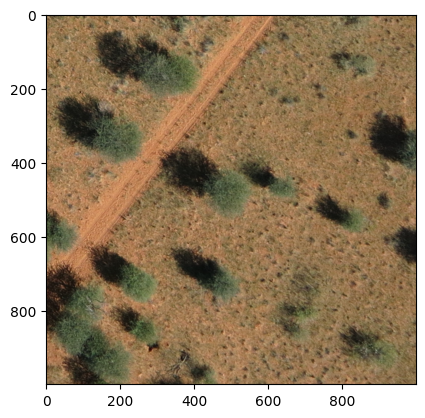

In [30]:
plt.imshow(tile)
plt.show()

In [17]:
height,width


(3000, 4000)

# Sahi tutorials

In [2]:
from sahi.slicing import slice_coco
from sahi.utils.file import load_json
from skimage.io import imread,imsave
import matplotlib.pyplot as plt
import os
import pandas as pd
import math
import shutil
from pathlib import Path
from arguments import Arguments
from utils import save_df_as_yolo

c:\Users\fadel\miniconda3\envs\activelearning\Lib\site-packages\pydantic\_internal\_fields.py:160: UserWarning: Field "model_version" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
06/10/2024 09:36:03 - ERROR - albumentations.check_version -   Error fetching version info
Traceback (most recent call last):
  File "c:\Users\fadel\miniconda3\envs\activelearning\Lib\urllib\request.py", line 1344, in do_open
    h.request(req.get_method(), req.selector, req.data, headers,
  File "c:\Users\fadel\miniconda3\envs\activelearning\Lib\http\client.py", line 1336, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "c:\Users\fadel\miniconda3\envs\activelearning\Lib\http\client.py", line 1382, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "c:\Users\fadel\miniconda3\envs\activelearning\Lib\http\client.py", line 1331, in 

In [138]:
coco_dict = load_json(r"..\exported_annotations\coco-format\result.json")
coco_dict

{'images': [{'width': 4000,
   'height': 3000,
   'id': 0,
   'file_name': 'C:\\Users\\fadel\\AppData\\Local\\label-studio\\label-studio\\media\\upload\\1\\1ca0f329-00a033fefe644429a1e0fcffe88f8b39.JPG'},
  {'width': 4000,
   'height': 3000,
   'id': 1,
   'file_name': 'C:\\Users\\fadel\\AppData\\Local\\label-studio\\label-studio\\media\\upload\\1\\21a5535d-0a3ed15cfab4453795564140e8fde8ba.JPG'}],
 'categories': [{'id': 0, 'name': 'specie1'}, {'id': 1, 'name': 'specie2'}],
 'annotations': [{'id': 0,
   'image_id': 0,
   'category_id': 0,
   'segmentation': [],
   'bbox': [531.0796780392291,
    1042.7917670520753,
    43.831912007076426,
    26.503016562418296],
   'ignore': 0,
   'iscrowd': 0,
   'area': 1161.677889886008},
  {'id': 1,
   'image_id': 1,
   'category_id': 0,
   'segmentation': [],
   'bbox': [1494.247966515887,
    1111.2070449963053,
    29.183302183780317,
    37.25527938354922],
   'ignore': 0,
   'iscrowd': 0,
   'area': 1087.2320761912779}],
 'info': {'year': 2024

In [4]:
coco_dict, coco_path = slice_coco(
    coco_annotation_file_path=r"C:\Users\fadel\OneDrive\Bureau\WILD-AI\datalabeling\exported_annotations\coco-format\result.json",
    image_dir="C:\\Users\\fadel\\AppData\\Local\\label-studio\\label-studio\\media\\upload\\1",
    output_coco_annotation_file_name="sliced_coco.json",
    ignore_negative_samples=False,
    # output_dir=r"C:\Users\fadel\OneDrive\Bureau\WILD-AI\datalabeling\exported_annotations\coco-format\images",
    slice_height=640,
    slice_width=640,
    overlap_height_ratio=0.2,
    overlap_width_ratio=0.2,
    min_area_ratio=0.1,
    verbose=True,
)

indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]06/10/2024 09:36:23 - INFO - sahi.slicing -   image.shape: (4000, 3000)
06/10/2024 09:36:23 - INFO - sahi.slicing -   Num slices: 48 slice_height: 640 slice_width: 640
 50%|█████     | 1/2 [00:00<00:00,  2.21it/s]06/10/2024 09:36:23 - INFO - sahi.slicing -   image.shape: (4000, 3000)
06/10/2024 09:36:24 - INFO - sahi.slicing -   Num slices: 48 slice_height: 640 slice_width: 640
100%|██████████| 2/2 [00:00<00:00,  2.41it/s]


In [5]:
coco_dict

{'images': [{'height': 640,
   'width': 640,
   'id': 1,
   'file_name': '1ca0f329-00a033fefe644429a1e0fcffe88f8b39_0_0_0_640_640.png'},
  {'height': 640,
   'width': 640,
   'id': 2,
   'file_name': '1ca0f329-00a033fefe644429a1e0fcffe88f8b39_0_512_0_1152_640.png'},
  {'height': 640,
   'width': 640,
   'id': 3,
   'file_name': '1ca0f329-00a033fefe644429a1e0fcffe88f8b39_0_1024_0_1664_640.png'},
  {'height': 640,
   'width': 640,
   'id': 4,
   'file_name': '1ca0f329-00a033fefe644429a1e0fcffe88f8b39_0_1536_0_2176_640.png'},
  {'height': 640,
   'width': 640,
   'id': 5,
   'file_name': '1ca0f329-00a033fefe644429a1e0fcffe88f8b39_0_2048_0_2688_640.png'},
  {'height': 640,
   'width': 640,
   'id': 6,
   'file_name': '1ca0f329-00a033fefe644429a1e0fcffe88f8b39_0_2560_0_3200_640.png'},
  {'height': 640,
   'width': 640,
   'id': 7,
   'file_name': '1ca0f329-00a033fefe644429a1e0fcffe88f8b39_0_3072_0_3712_640.png'},
  {'height': 640,
   'width': 640,
   'id': 8,
   'file_name': '1ca0f329-00a03

In [6]:
def save_tiles(df_tiles:pd.DataFrame,out_img_dir:str,clear_out_img_dir:bool):

    # clear out_img_dir
    if clear_out_img_dir:
        print('Deleting images in ',out_img_dir)
        shutil.rmtree(out_img_dir)
        Path(out_img_dir).mkdir(parents=True,exist_ok=True) 

    for idx in tqdm(df_tiles.index,desc='Saving tiles'):
        x0 = int(df_tiles.at[idx,'x0'])
        x1 = int(df_tiles.at[idx,'x1'])
        y0 = int(df_tiles.at[idx,'y0'])
        y1 = int(df_tiles.at[idx,'y1'])
        img_path = df_tiles.at[idx,'parent_images']
        tile_name = df_tiles.at[idx,'images']
        img = imread(img_path)
        tile = img[y0:y1,x0:x1,:]
        imsave(fname=os.path.join(out_img_dir,tile_name),arr=tile)


def sample_data(coco_dict_slices:dict,
                img_dir:str,
                empty_ratio:int=3,
                out_csv_path:str=None):
    
    assert (empty_ratio >= 0) and isinstance(empty_ratio,int),'Provide appropriate value'

    def get_parent_image(file_name:str,lookup_extensions:list[str] = ['jpg','png','tif','JPG','PNG','TIF']):
        file_name = os.path.basename(file_name)
        parent_file = '_'.join(file_name.split('_')[:-5])
        for ext in lookup_extensions:
            parent_file = os.path.join(img_dir,parent_file+f'.{ext}')
            if os.path.exists(parent_file):
                # print(parent_file)
                break
            else:
                # print(parent_file)
                raise FileNotFoundError('Parent file note found.')
        return parent_file

    
    # build mapping for labels
    label_ids = [cat['id'] for cat in coco_dict_slices['categories']]
    label_name = [cat['name'] for cat in coco_dict_slices['categories']]
    label_map = dict(zip(label_ids,label_name))

    # build dataFrame of image slices 
    ids = list()
    x0s, x1s = list(), list()
    y0s, y1s = list(), list()
    file_paths = list()
    parent_file_paths = list()
    for metadata in coco_dict_slices['images']:
        # img_path = os.path.join(img_dir,metadata['file_name'])
        file_paths.append(metadata['file_name'])
        file_name = os.path.basename(metadata['file_name'])
        x_0,y_0,x_1,y_1 = file_name.split('.')[0].split('_')[-4:]
        parent_image = get_parent_image(file_name)
        parent_file_paths.append(parent_image)
        x0s.append(x_0)
        x1s.append(x_1)
        y0s.append(y_0)
        y1s.append(y_1)
        ids.append(metadata['id'])
    df_limits = {'x0':x0s,
                 'x1':x1s,
                 'y0':y0s,
                 'y1':y1s,
                 'id':ids,
                 'images':file_paths,
                 'parent_images':parent_file_paths
                 }
    df_limits = pd.DataFrame.from_dict(df_limits,orient='columns')
    df_limits.set_index('id',inplace=True)

    # build dataframe of annotations
    x_mins, y_mins = list(), list()
    widths, heights = list(), list()
    ids_annot = list()
    label_ids = list()
    for annot in coco_dict['annotations']:
        ids_annot.append(annot['image_id'])
        x,y,w,h = annot['bbox']
        label_ids.append(annot['category_id'])
        x_mins.append(x)
        y_mins.append(y)
        widths.append(w)
        heights.append(h)
    df_annot = {'x_min':x_mins,
                'y_min':y_mins,
                'width':widths,
                'height':heights,
                'id':ids_annot,
                'label_id':label_ids}
    df_annot = pd.DataFrame.from_dict(df_annot,orient='columns') 
    df_annot.set_index('id',inplace=True)
    df_annot['labels'] = df_annot['label_id'].map(label_map)
    for col in ['x_min','y_min','width','height']:
        df_annot[col] = df_annot[col].apply(math.floor)

    # join dataframes
    df = df_limits.join(df_annot,how='outer') 
    # get empty df and tiles
    df_empty = df[df['x_min'].isna()]
    df_non_empty = df[~df['x_min'].isna()]
    empty_num =  int(len(df_non_empty)*empty_ratio)
    df_empty = df_empty.sample(n=empty_num,random_state=41,replace=False)
    # concat dfs
    df = pd.concat([df_empty,df[~df['x_min'].isna()]],axis=0)
    df.reset_index(inplace=True)

    # create x_center and y_center
    df['x'] = df['x_min'] + df['width']*0.5
    df['y'] = df['y_min'] + df['height']*0.5

    # save df
    if out_csv_path is not None:
        df.to_csv(out_csv_path,sep=',',index=False)

    return df

df = sample_data(coco_dict,
                empty_ratio=1,
                img_dir="C:\\Users\\fadel\\AppData\\Local\\label-studio\\label-studio\\media\\upload\\1",
                out_csv_path=r"C:\Users\fadel\OneDrive\Bureau\WILD-AI\datalabeling\exported_annotations\coco-format\sample.csv",
                out_img_dir=r"C:\Users\fadel\OneDrive\Bureau\WILD-AI\datalabeling\data\train\images",
                clear_out_img_dir=True)
df

Deleting images in  C:\Users\fadel\OneDrive\Bureau\WILD-AI\datalabeling\data\train\images


Saving tiles: 100%|██████████| 12/12 [00:08<00:00,  1.40it/s]


,id,x0,x1,y0,y1,images,parent_images,x_min,y_min,width,height,label_id,labels,x,y
0,88,3360,4000,2048,2688,21a5535d-0a3ed15cfab4453795564140e8fde8ba_1_33...,C:\Users\fadel\AppData\Local\label-studio\labe...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,30,2560,3200,1536,2176,1ca0f329-00a033fefe644429a1e0fcffe88f8b39_0_25...,C:\Users\fadel\AppData\Local\label-studio\labe...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,90,512,1152,2360,3000,21a5535d-0a3ed15cfab4453795564140e8fde8ba_1_51...,C:\Users\fadel\AppData\Local\label-studio\labe...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,70,2560,3200,1024,1664,21a5535d-0a3ed15cfab4453795564140e8fde8ba_1_25...,C:\Users\fadel\AppData\Local\label-studio\labe...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,7,3072,3712,0,640,1ca0f329-00a033fefe644429a1e0fcffe88f8b39_0_30...,C:\Users\fadel\AppData\Local\label-studio\labe...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,66,512,1152,1024,1664,21a5535d-0a3ed15cfab4453795564140e8fde8ba_1_51...,C:\Users\fadel\AppData\Local\label-studio\labe...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,9,0,640,512,1152,1ca0f329-00a033fefe644429a1e0fcffe88f8b39_0_0_...,C:\Users\fadel\AppData\Local\label-studio\labe...,531.0,530.0,43.0,26.0,0.0,specie1,552.5,543.0
7,10,512,1152,512,1152,1ca0f329-00a033fefe644429a1e0fcffe88f8b39_0_51...,C:\Users\fadel\AppData\Local\label-studio\labe...,19.0,530.0,43.0,26.0,0.0,specie1,40.5,543.0
8,17,0,640,1024,1664,1ca0f329-00a033fefe644429a1e0fcffe88f8b39_0_0_...,C:\Users\fadel\AppData\Local\label-studio\labe...,531.0,18.0,43.0,26.0,0.0,specie1,552.5,31.0
9,18,512,1152,1024,1664,1ca0f329-00a033fefe644429a1e0fcffe88f8b39_0_51...,C:\Users\fadel\AppData\Local\label-studio\labe...,19.0,18.0,43.0,26.0,0.0,specie1,40.5,31.0


In [8]:
args = Arguments()
save_df_as_yolo(df_annotation=df[~df['x'].isna()].copy(),args=args)


In [17]:
def build_yolo_dataset(label_studio_jsons)

(96, 6)